In [1]:
# load the change in the files
%load_ext autoreload
%autoreload 2

In [2]:
!pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np

/Users/sagarpatil/anaconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining the forward diffusion process


In [3]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [12]:
timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [40]:
import os
import sys
# append the parent directory to path
# sys.path.append('/home/miyen/diffusion-features/diffusion-features')
sys.path.append('/Users/sagarpatil/sagar/projects/diffusion-features/diffusion-features/')
from utils.get_trajectories import get_trajectories
trajectories = get_trajectories()
trajectories = torch.tensor(trajectories, dtype=torch.float32)
print(trajectories.shape)
x_start = trajectories[30].unsqueeze(0)
x_start = x_start.float()
print(x_start)

/Users/sagarpatil/sagar/projects/diffusion-features/environment/data/lavaenv
torch.Size([1033, 16, 2])
torch.Size([1033, 16, 2])
tensor([[[1., 4.],
         [1., 3.],
         [1., 2.],
         [2., 2.],
         [3., 2.],
         [4., 2.],
         [5., 2.],
         [6., 2.],
         [7., 2.],
         [8., 2.],
         [8., 3.],
         [8., 4.],
         [8., 5.],
         [8., 6.],
         [8., 7.],
         [8., 8.]]])


/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_51800/1557794813.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trajectories = torch.tensor(trajectories, dtype=torch.float32)


In [29]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [30]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  # noisy_image = reverse_transform(x_noisy.squeeze())

  return x_noisy

In [31]:
# take time step
t = torch.tensor([40])

x_noisy = get_noisy_image(x_start, t)


<img src="https://drive.google.com/uc?id=1Ra33wxuw3QxPlUG0iqZGtxgKBNdjNsqz" width="100" />

Let's visualize this for various time steps:

tensor([[[1., 4.],
         [1., 3.],
         [1., 2.],
         [2., 2.],
         [3., 2.],
         [4., 2.],
         [5., 2.],
         [6., 2.],
         [7., 2.],
         [8., 2.],
         [8., 3.],
         [8., 4.],
         [8., 5.],
         [8., 6.],
         [8., 7.],
         [8., 8.]]])
tensor([[[0.9841, 3.9976],
         [1.0123, 2.9964],
         [0.9840, 1.9940],
         [2.0050, 1.9933],
         [3.0186, 2.0145],
         [4.0146, 2.0017],
         [4.9964, 1.9998],
         [5.9898, 2.0100],
         [7.0042, 1.9768],
         [8.0109, 2.0004],
         [7.9971, 3.0106],
         [8.0109, 4.0076],
         [8.0153, 5.0185],
         [8.0011, 6.0032],
         [7.9910, 6.9922],
         [8.0046, 7.9951]]])


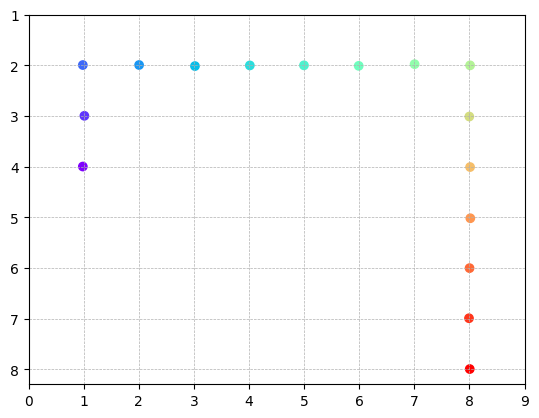

tensor([[[0.8529, 3.8779],
         [0.7732, 2.9417],
         [0.8617, 1.4476],
         [1.8940, 1.7997],
         [2.8752, 1.6314],
         [3.6811, 2.2594],
         [4.8428, 2.2023],
         [5.9606, 2.1582],
         [6.7634, 2.1330],
         [7.8099, 1.7748],
         [7.6056, 2.8869],
         [8.1620, 3.8837],
         [7.6524, 5.2750],
         [8.1370, 6.2589],
         [7.7085, 6.9238],
         [8.1792, 7.8301]]])


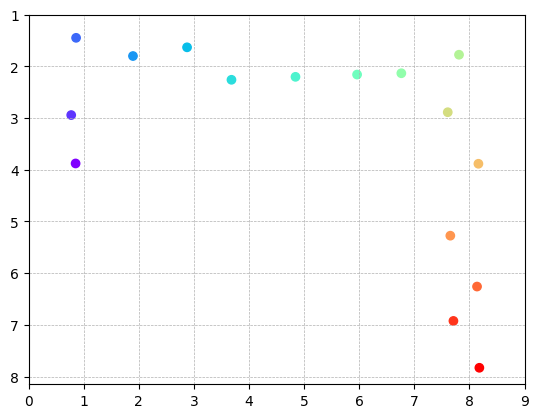

tensor([[[ 0.9065,  4.1631],
         [-0.0481,  2.7239],
         [ 0.6732,  1.6019],
         [ 1.8825,  0.6295],
         [ 2.2624,  2.3151],
         [ 3.3155,  1.6541],
         [ 4.9048,  1.7972],
         [ 5.2312,  1.0526],
         [ 6.6117,  2.0428],
         [ 7.8391,  1.7179],
         [ 7.7334,  1.4423],
         [ 6.9085,  3.6394],
         [ 7.6098,  4.2195],
         [ 7.2361,  5.0238],
         [ 7.3699,  6.4024],
         [ 7.0542,  7.4105]]])


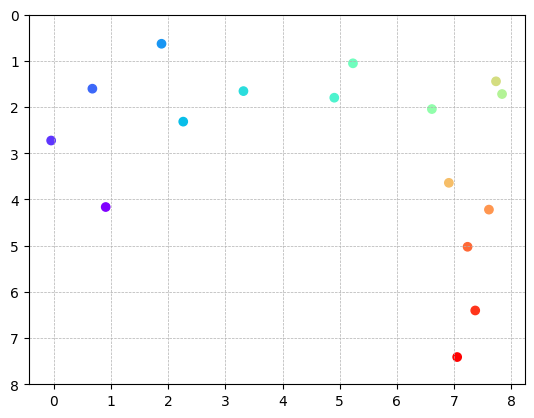

tensor([[[1.4379, 3.5583],
         [1.5466, 2.2322],
         [1.0215, 0.9622],
         [1.1319, 1.7572],
         [2.5269, 2.3349],
         [3.9051, 0.9841],
         [3.7793, 1.2688],
         [4.8090, 2.2993],
         [5.1215, 1.7023],
         [6.6334, 2.8488],
         [5.7877, 3.1691],
         [6.0237, 3.8322],
         [6.0524, 5.4779],
         [7.0043, 5.3645],
         [7.0573, 5.1842],
         [6.0890, 5.6782]]])


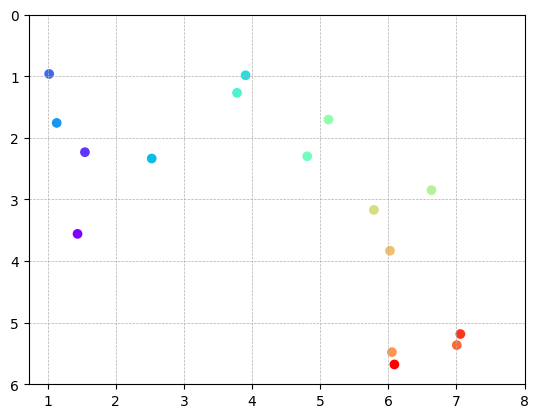

tensor([[[ 0.8671,  2.6648],
         [-0.1103,  0.1383],
         [ 0.6176, -0.1924],
         [ 0.2325, -1.0545],
         [ 0.4562,  1.0473],
         [-0.7343, -1.7243],
         [ 0.3994, -2.0694],
         [-1.2797, -0.0221],
         [ 2.2266,  1.3441],
         [ 0.4628, -0.4873],
         [ 1.9723, -0.0127],
         [ 2.6262,  2.8673],
         [-0.1494, -0.4458],
         [ 1.5508,  1.7615],
         [ 0.5899,  0.9727],
         [ 0.6107,  0.5811]]])


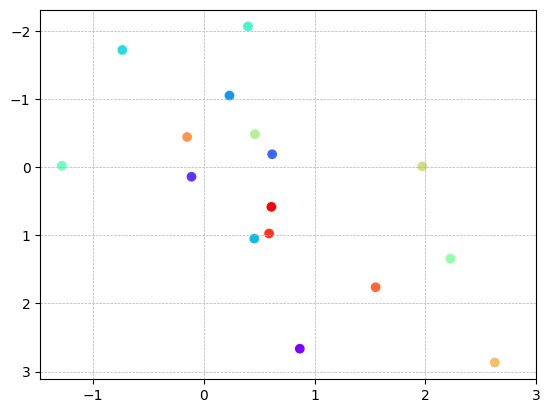

tensor([[[-1.0128,  0.6199],
         [ 0.1086,  1.3195],
         [ 0.1694,  0.0721],
         [-0.6669, -0.0432],
         [ 0.4241, -0.6416],
         [-1.0117, -1.4110],
         [ 0.7159,  0.7138],
         [-0.5829,  1.8313],
         [ 1.6895, -1.2015],
         [ 2.0026,  1.5090],
         [ 0.3829, -0.6972],
         [-0.1505,  2.6775],
         [-0.2369, -0.7841],
         [ 0.3903,  0.4152],
         [ 1.2763,  0.7174],
         [-0.6568,  0.1743]]])


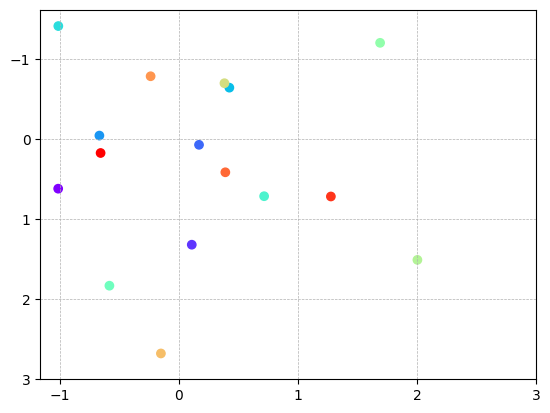

In [32]:
# plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])
from utils.get_trajectories import visualize_trajectory
# normalize the x_start by the size of the maze which is 8
print(x_start)
# x_start_normalized = x_start / 8
# print(torch.mean(x_start_normalized))
# print(torch.std(x_start_normalized))
# # make them in range [-1, 1]
# x_start_normalized = (x_start_normalized * 2) - 1
# print(x_start_normalized)

for t in [0, 50, 100, 150, 400, 499]:
  x_noisy = get_noisy_image(x_start, torch.tensor([t]))
  print(x_noisy)
    # print the mean and std of the noisy image
    # print(torch.mean(x_noisy))
    # print(torch.std(x_noisy))
  visualize_trajectory(x_noisy)

In [33]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1", condition=None):
    if noise is None:
        noise = torch.randn_like(x_start)
        
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, global_cond=condition)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [34]:
@torch.no_grad()
def p_sample(model, x, t, t_index, global_cond=None):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, global_cond) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape, global_cond=None):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i, global_cond=global_cond)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

@torch.no_grad()
def sample_trajectories(model, traj_size, batch_size=16, output_dim = 2, global_cond=None):
    return p_sample_loop(model, shape=(batch_size, traj_size, output_dim), global_cond=global_cond)


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [35]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [36]:
# Taken from https://diffusion-policy.cs.columbia.edu/
import logging
import math
from typing import List, Optional, Tuple, Union
import typing

import torch
from torch import nn

# @markdown ### **Network**
# @markdown
# @markdown Defines a 1D UNet architecture `ConditionalUnet1D`
# @markdown as the noies prediction network
# @markdown
# @markdown Components
# @markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
# @markdown - `Downsample1d` Strided convolution to reduce temporal resolution
# @markdown - `Upsample1d` Transposed convolution to increase temporal resolution
# @markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
# @markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
# @markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
# @markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(1000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups,),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups,),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels,), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1,)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim: int,
        global_cond_dim: int,
        down_dims: List[int],
        diffusion_step_embed_dim: int,
        kernel_size: int = 5,
        n_groups: int = 8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines number of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size, n_groups=n_groups),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

    def forward(
        self,
        sample: torch.Tensor,
        timestep: torch.Tensor,
        global_cond: Optional[torch.Tensor] = None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B, global_cond_dim)
        output: (B,T,input_dim)
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        # (B,T,C)
        sample = sample.moveaxis(-1, -2)

        # 1. time
        timesteps = timestep
        if timesteps.shape == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])
        timesteps = timesteps.to(sample.device)

        global_feature = self.diffusion_step_encoder(timesteps)
        global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        # print('downsampling')
        for resnet, resnet2, downsample in self.down_modules:
            # print('x shape:', x.shape)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            # print('h shape:', h[-1].shape)
            x = downsample(x)


        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)
        # print('upsampling')
        for resnet, resnet2, upsample in self.up_modules:
            # print('x shape:', x.shape)
            # print('h shape:', h[-1].shape)
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

In [41]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# trajectories = trajectories[0:32]
trajectories_size = trajectories.shape
print(trajectories_size)
# model = Unet(
#     dim=trajectories_size[1],
#     channels=channels,
#     dim_mults=(1, 2, 4,)
# )
# TODO: double check down_dims
model = ConditionalUnet1D(
    input_dim=2,
    global_cond_dim=0,
    down_dims=[16, 32, 64],
    diffusion_step_embed_dim=trajectories_size[1],
    kernel_size=3,
    n_groups=1,
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

cpu
torch.Size([1033, 16, 2])


Let's start training!

In [42]:
# print the total number of trajectories
print(trajectories.shape)


torch.Size([1033, 16, 2])


In [43]:
from torchvision.utils import save_image
from torch.utils.data import DataLoader

epochs = 100
batch_size = 8
# channels = 1
dataloader = DataLoader(trajectories, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()
      
      
      b = batch.shape[0]
      batch = batch.to(device)
      # batch shape: (B, T, C)
      print('input shape pre reshape', batch.shape)

      # batch = batch.reshape(b, channels, batch.shape[1], batch.shape[2])
      
      # normalize the batch to [-1, 1]
      batch = (batch / 8) * 2 - 1
      
      # generate conditioning based on start and end states
      # start_states = batch[:, 0, :]
      # end_states = batch[:, -1, :]
      # condition = torch.cat((start_states, end_states), axis=1)
      condition = None
      # print('condition shape', condition.shape)
      
      # print("batch: ", torch.mean(batch[4]), torch.std(batch[4]))
      # print("Max and min", torch.max(batch[4]), torch.min(batch[4]))

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t, loss_type="huber", condition=condition)

      # if step % 100 == 0:
      print("Loss:", loss.item())

      loss.backward()
      optimizer.step()

      # save generated images
      # if step != 0 and step % save_and_sample_every == 0:
      #   milestone = step // save_and_sample_every
      #   batches = num_to_groups(4, batch_size)
      #   all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
      #   all_images = torch.cat(all_images_list, dim=0)
      #   all_images = (all_images + 1) * 0.5
      #   save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4767497181892395
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.41289639472961426
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.42761099338531494
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.38237154483795166
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4885045289993286
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.44338753819465637
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.41051363945007324
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.47132718563079834
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.42075085639953613
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.38835397362709045
input shape pre reshape torch.Size([8, 16, 2])


/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_51800/566316448.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)


Loss: 0.421689510345459
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4136643409729004
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.38376712799072266
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.41738206148147583
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3982296586036682
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3674335479736328
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.39103081822395325
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3769083023071289
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.4073050618171692
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.38267338275909424
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.34089189767837524
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.41373321413993835
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.3310399055480957
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.38248199224472046
input shape pre reshape torch.Siz

/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_51800/1167613155.py:13: UserWarning: Using a target size (torch.Size([8, 16, 2])) that is different to the input size (torch.Size([1, 16, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.smooth_l1_loss(noise, predicted_noise)


input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.09394478797912598
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.1807071566581726
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.17282956838607788
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.1428004652261734
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.12941835820674896
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.1841224879026413
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.08831724524497986
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.11513620615005493
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.07610291242599487
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.13635209202766418
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.14035142958164215
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.09916070103645325
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.139288067817688
input shape pre reshape torch.Size([8, 16, 2])
Loss: 0.1

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [44]:
# global_cond = torch.tensor([0, 0, 1, 1]).unsqueeze(0).to(device)
global_cond = None
samples = sample_trajectories(model=model, traj_size=16, batch_size=1, output_dim=2, global_cond=global_cond)
print(len(samples))

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]/var/folders/dp/tcw5kkkx5vg3j7fhb1fxq12c0000gn/T/ipykernel_51800/566316448.py:264: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  global_feature = torch.tensor(global_feature, dtype=torch.float32, device = device)
sampling loop time step: 100%|██████████| 500/500 [00:00<00:00, 500.90it/s]

500


(1, 16, 2)
[[[ 6.554449    1.8789458 ]
  [ 8.200634   -1.5280013 ]
  [ 6.3187857   6.651633  ]
  [ 3.5248015   9.405796  ]
  [ 8.8420925   1.0952568 ]
  [ 6.579745   10.619897  ]
  [ 5.743666    5.8805165 ]
  [ 5.4101267  -1.8760252 ]
  [ 1.9006844   3.1288133 ]
  [-3.1288714   6.7651277 ]
  [ 4.2099123   0.7538948 ]
  [-2.199205    2.4074812 ]
  [ 4.033238    8.453802  ]
  [ 0.88784456 -2.3951397 ]
  [-2.7837062   3.775988  ]
  [ 7.375394    8.125948  ]]]


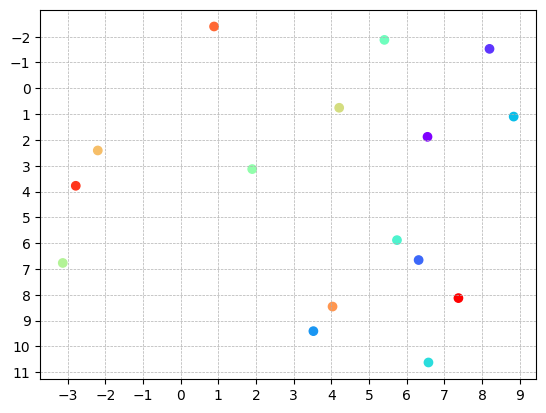

(1, 16, 2)
[[[ 0.0863142   4.899082  ]
  [ 8.188202   -0.64176464]
  [ 1.5707588  -0.5746722 ]
  [ 1.8265607  10.806799  ]
  [ 9.483666    3.0028627 ]
  [ 4.599628    7.3629475 ]
  [ 6.43783     3.8071978 ]
  [ 7.6807127   4.836274  ]
  [ 4.6838026   2.0633667 ]
  [ 6.656822    6.357923  ]
  [ 3.228111    3.6361837 ]
  [-1.3780618   2.912747  ]
  [ 4.995362    2.1642377 ]
  [-0.19631147  0.08557558]
  [-6.6868544   3.0800552 ]
  [ 5.4089546   6.6280437 ]]]


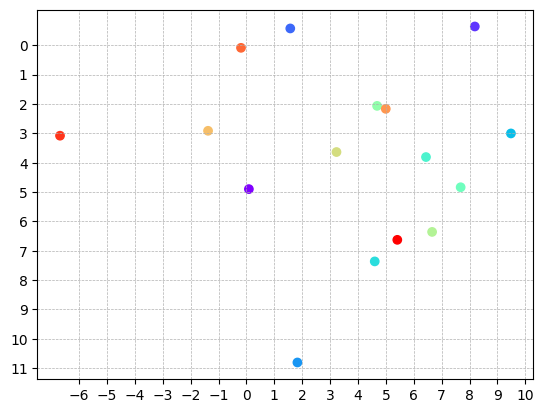

(1, 16, 2)
[[[ 0.7424531   6.333187  ]
  [ 9.189321    2.4353147 ]
  [ 2.5956101  -3.650998  ]
  [ 3.3994677   8.404007  ]
  [ 8.430359    0.4742298 ]
  [-3.6969318   6.606658  ]
  [ 1.9132047  -0.01426077]
  [ 5.8791695   6.8755264 ]
  [ 4.310218   -1.7423129 ]
  [ 1.4388053   3.3633575 ]
  [ 2.782813   10.419538  ]
  [-4.4736233   1.0074663 ]
  [ 3.4192498  -4.2183485 ]
  [ 4.9850698   0.5091071 ]
  [-4.337513   -0.2474289 ]
  [ 2.4873257   7.347989  ]]]


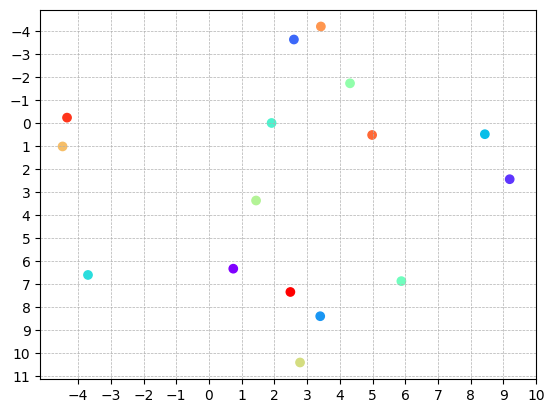

(1, 16, 2)
[[[ 2.1196818  4.7312913]
  [ 8.985315  11.943499 ]
  [-2.4985876  2.903193 ]
  [-0.5991173  9.749348 ]
  [ 7.1065826  7.7245255]
  [ 3.605511  14.160961 ]
  [ 6.4239645  2.4734316]
  [10.418453   1.175381 ]
  [ 3.7995005  2.1573968]
  [ 3.2100062  3.3658936]
  [-1.3396053  5.271944 ]
  [-2.4635873 -0.5515113]
  [ 3.2445283 -7.057413 ]
  [ 9.2785225 -3.773149 ]
  [-8.235496   2.882903 ]
  [-1.880866   5.8835125]]]


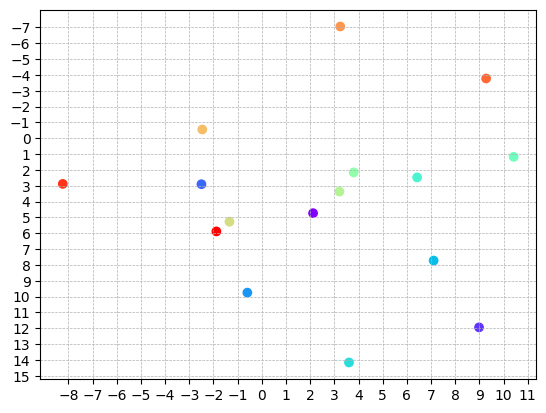

(1, 16, 2)
[[[-0.73543787  7.763572  ]
  [ 4.2237206   2.881444  ]
  [ 2.7102394   5.6053085 ]
  [ 0.34323525  6.098001  ]
  [ 2.8009996   7.71511   ]
  [ 2.102871    7.0406704 ]
  [ 3.6396613   8.651707  ]
  [ 8.406124    3.7397833 ]
  [ 5.6684623   6.954072  ]
  [ 8.337809    3.8460891 ]
  [ 0.4728322   0.6162391 ]
  [ 1.489752   -2.110889  ]
  [-0.28777313 -3.7031918 ]
  [-0.88947487 -1.2289209 ]
  [-1.1462011   1.9974372 ]
  [ 0.72588015  0.96136713]]]


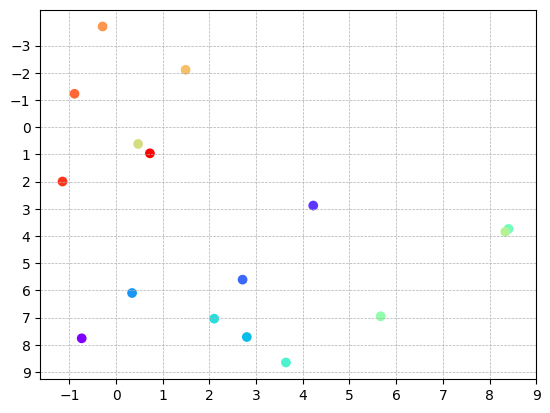

(1, 16, 2)
[[[ 1.8442137   4.5363193 ]
  [ 1.2551277   5.201571  ]
  [ 1.0548425   5.778435  ]
  [ 1.1529169   6.3120327 ]
  [ 1.6595414   6.831644  ]
  [ 2.5515947   7.0785894 ]
  [ 3.3411074   7.0497866 ]
  [ 4.36451     6.657361  ]
  [ 4.987476    5.863136  ]
  [ 5.5527782   4.9672995 ]
  [-0.10842276  0.07296801]
  [-0.17672205  0.00915313]
  [-0.21565056 -0.02597761]
  [-0.1843462  -0.07137108]
  [-0.18103695 -0.07463932]
  [-0.13264036 -0.08711338]]]


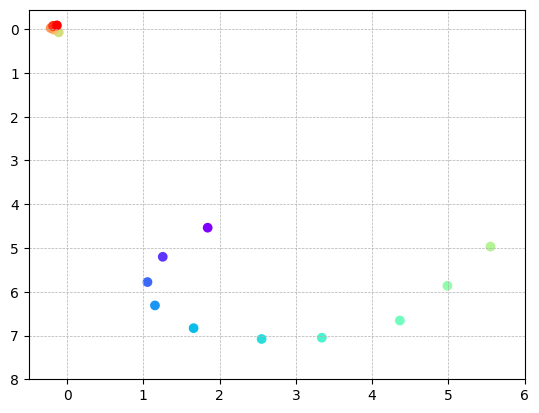

In [45]:
# show a random one
from utils.get_trajectories import visualize_trajectory
import numpy as np

# random_index = 180
# print(samples[random_index].shape)
# print(samples[random_index])
# random_sample = samples[random_index][0]
# print(np.mean(random_sample))
# print(np.std(random_sample))
# # plot the trajectory
# visualize_trajectory(random_sample)

# print the final trajectory
# samples[-1] = ((samples[-1]+1)/2) * 8 # denormalize
# print(samples[-1].shape)
# print(samples[-1])
# visualize_trajectory(samples[-1])


for i in [0, 50, 100, 200, 400, 499]:
  samples[i] = ((samples[i]+1)/2) * 8 # denormalize
  print(samples[i].shape)
  print(samples[i])
  visualize_trajectory(samples[i])

<img src="https://drive.google.com/uc?id=1ytnzS7IW7ortC6ub85q7nud1IvXe2QTE" width="300" />